# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../datasets/cleaned_dataset.csv')

df = df[[
         'HDays', 'ADays',
         'HASLxM', 'HASTLxM', 
         'HACLxM', 'HAFLxM', 'HAYCLxM', 'HARCLxM',
         'HAGSLxM', 'HAGCLxM', 'HAGSLxHM', 'HAGCLxHM',
         'HGDLxM', 'HGDLxHM', 'HAPLxM', 'HAPLxHM',
         'HWPLxM', 'HWPLxHM',
         'HWinStreak',
         'AASLxM', 'AASTLxM', 
         'AACLxM', 'AAFLxM', 'AAYCLxM', 'AARCLxM',
         'AAGSLxM', 'AAGCLxM', 'AAGSLxAM', 'AAGCLxAM',
         'AGDLxM', 'AGDLxAM', 'AAPLxM','AAPLxAM',
         'AWPLxM', 'AWPLxAM', 
         'AWinStreak', 
         'HDef', 'HMid', 'HAtt', 'HOvr',
         'ADef', 'AMid', 'AAtt', 'AOvr',
         'B365H', 'B365D', 'B365A',
         'Venue',
         'Result'
        ]]

df = df.dropna(axis=0).reset_index(drop=True)

# 3. Feature Selection

In [4]:
selected_features = ['HASLxM', 'HAGCLxM', 'HWPLxM', 'AASLxM', 'AAFLxM', 'AAGCLxM', 'AWPLxM', 'HOvr', 'AOvr', 'B365H', 'B365D','B365A', 'Venue']

# 4. Model Building- Data Split 2

- Target Variable: Draw/ Non-Draw
- Balanced Sampling

In [5]:
# label encode categorical feature- VENUE
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

dict(zip(venue_le.classes_, range(len(venue_le.classes_))))

{'Anfield': 0,
 'Bet365 Stadium': 1,
 'Boleyn Ground': 2,
 'Bramall Lane': 3,
 'Brentford Community Stadium': 4,
 'Cardiff City Stadium': 5,
 'Carrow Road': 6,
 'Craven Cottage': 7,
 'DW Stadium': 8,
 'Dean Court': 9,
 'Elland Road': 10,
 'Emirates Stadium': 11,
 'Etihad Stadium': 12,
 'Falmer Stadium': 13,
 'Goodison Park': 14,
 'Hull City Stadium': 15,
 'King Power Stadium': 16,
 'Kirklees Stadium': 17,
 'Loftus Road': 18,
 'London Stadium': 19,
 'Madejski Stadium': 20,
 'Molineux Stadium': 21,
 'Old Trafford': 22,
 'Riverside Stadium': 23,
 'Selhurst Park': 24,
 "St Mary's Stadium": 25,
 'St. James Park': 26,
 'Stadium of Light': 27,
 'Stamford Bridge': 28,
 'Swansea.com Stadium': 29,
 'The Hawthorns': 30,
 'Tottenham Hotspur Stadium': 31,
 'Turf Moor': 32,
 'Vicarage Road': 33,
 'Villa Park': 34,
 'Wembley Stadium': 35,
 'White Hart Lane': 36}

### Random Forest Classifier

#### Fold 1

In [6]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


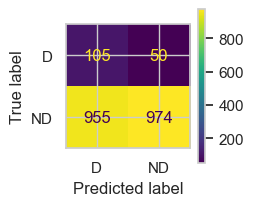

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [8]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5177543186180422
ROC score on Test Set: 0.6018411679125069

              precision    recall  f1-score   support

           0       0.10      0.68      0.17       155
           1       0.95      0.50      0.66      1929

    accuracy                           0.52      2084
   macro avg       0.53      0.59      0.42      2084
weighted avg       0.89      0.52      0.62      2084



#### Fold 2

In [9]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


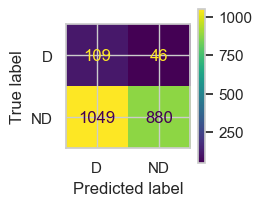

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.47456813819577737
ROC score on Test Set: 0.6004080335791568

              precision    recall  f1-score   support

           0       0.09      0.70      0.17       155
           1       0.95      0.46      0.62      1929

    accuracy                           0.47      2084
   macro avg       0.52      0.58      0.39      2084
weighted avg       0.89      0.47      0.58      2084



#### Fold 3

In [12]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


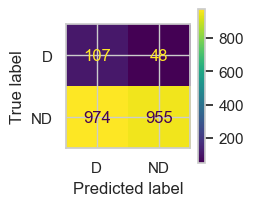

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5095969289827256
ROC score on Test Set: 0.6034967139918728

              precision    recall  f1-score   support

           0       0.10      0.69      0.17       155
           1       0.95      0.50      0.65      1929

    accuracy                           0.51      2084
   macro avg       0.53      0.59      0.41      2084
weighted avg       0.89      0.51      0.62      2084



#### Fold 4

In [15]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


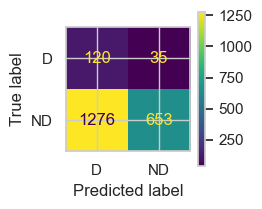

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.3709213051823417
ROC score on Test Set: 0.5945216475191892

              precision    recall  f1-score   support

           0       0.09      0.77      0.15       155
           1       0.95      0.34      0.50      1929

    accuracy                           0.37      2084
   macro avg       0.52      0.56      0.33      2084
weighted avg       0.88      0.37      0.47      2084



#### Fold 5

In [18]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


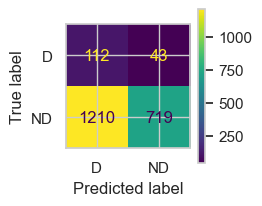

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.3987523992322457
ROC score on Test Set: 0.5709108847974046

              precision    recall  f1-score   support

           0       0.08      0.72      0.15       155
           1       0.94      0.37      0.53      1929

    accuracy                           0.40      2084
   macro avg       0.51      0.55      0.34      2084
weighted avg       0.88      0.40      0.51      2084



### Logistic Regression

#### Fold 1

In [21]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


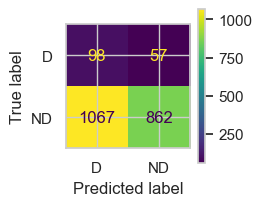

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.46065259117082535
ROC score on Test Set: 0.5721567250288466

              precision    recall  f1-score   support

           0       0.08      0.63      0.15       155
           1       0.94      0.45      0.61      1929

    accuracy                           0.46      2084
   macro avg       0.51      0.54      0.38      2084
weighted avg       0.87      0.46      0.57      2084



#### Fold 2

In [24]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


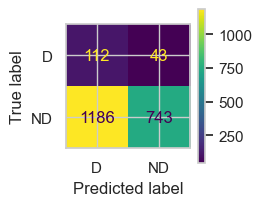

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4102687140115163
ROC score on Test Set: 0.573280489640295

              precision    recall  f1-score   support

           0       0.09      0.72      0.15       155
           1       0.95      0.39      0.55      1929

    accuracy                           0.41      2084
   macro avg       0.52      0.55      0.35      2084
weighted avg       0.88      0.41      0.52      2084



#### Fold 3

In [27]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


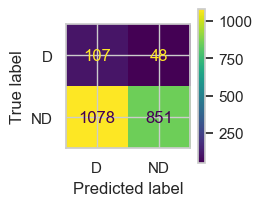

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4596928982725528
ROC score on Test Set: 0.591371093162093

              precision    recall  f1-score   support

           0       0.09      0.69      0.16       155
           1       0.95      0.44      0.60      1929

    accuracy                           0.46      2084
   macro avg       0.52      0.57      0.38      2084
weighted avg       0.88      0.46      0.57      2084



#### Fold 4

In [30]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


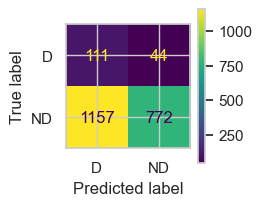

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.42370441458733205
ROC score on Test Set: 0.5618187595110287

              precision    recall  f1-score   support

           0       0.09      0.72      0.16       155
           1       0.95      0.40      0.56      1929

    accuracy                           0.42      2084
   macro avg       0.52      0.56      0.36      2084
weighted avg       0.88      0.42      0.53      2084



#### Fold 5

In [33]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


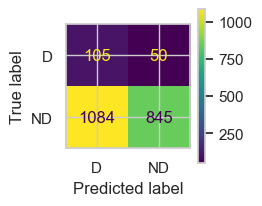

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [35]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.45585412667946257
ROC score on Test Set: 0.5525209451663071

              precision    recall  f1-score   support

           0       0.09      0.68      0.16       155
           1       0.94      0.44      0.60      1929

    accuracy                           0.46      2084
   macro avg       0.52      0.56      0.38      2084
weighted avg       0.88      0.46      0.57      2084



### SVM Classifier

#### Fold 1

In [36]:
# logistic regression
svc_classifier = SVC(kernel = 'rbf', C=10, gamma=0.01, random_state = 0, probability=True)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


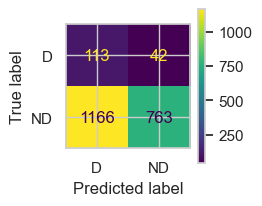

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.42034548944337813
ROC score on Test Set: 0.5784845900433118

              precision    recall  f1-score   support

           0       0.09      0.73      0.16       155
           1       0.95      0.40      0.56      1929

    accuracy                           0.42      2084
   macro avg       0.52      0.56      0.36      2084
weighted avg       0.88      0.42      0.53      2084



#### Fold 2

In [39]:
# logistic regression
svc_classifier = SVC(kernel = 'rbf', C=10, gamma=0.01, random_state = 0, probability=True)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


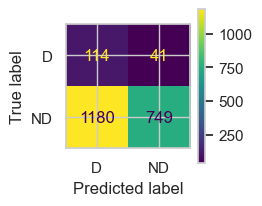

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.41410748560460653
ROC score on Test Set: 0.5722520443485677

              precision    recall  f1-score   support

           0       0.09      0.74      0.16       155
           1       0.95      0.39      0.55      1929

    accuracy                           0.41      2084
   macro avg       0.52      0.56      0.35      2084
weighted avg       0.88      0.41      0.52      2084



#### Fold 3

In [42]:
# logistic regression
svc_classifier = SVC(kernel = 'rbf', C=10, gamma=0.01, random_state = 0, probability=True)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


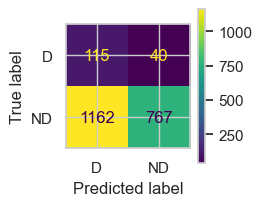

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.42322456813819576
ROC score on Test Set: 0.5732169434271477

              precision    recall  f1-score   support

           0       0.09      0.74      0.16       155
           1       0.95      0.40      0.56      1929

    accuracy                           0.42      2084
   macro avg       0.52      0.57      0.36      2084
weighted avg       0.89      0.42      0.53      2084



#### Fold 4

In [45]:
# logistic regression
svc_classifier = SVC(kernel = 'rbf', C=10, gamma=0.01, random_state = 0, probability=True)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


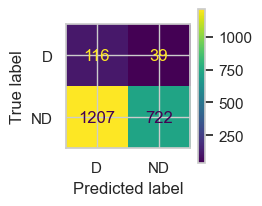

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [47]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4021113243761996
ROC score on Test Set: 0.5756969180086622

              precision    recall  f1-score   support

           0       0.09      0.75      0.16       155
           1       0.95      0.37      0.54      1929

    accuracy                           0.40      2084
   macro avg       0.52      0.56      0.35      2084
weighted avg       0.88      0.40      0.51      2084



#### Fold 5

In [48]:
# logistic regression
svc_classifier = SVC(kernel = 'rbf', C=10, gamma=0.01, random_state = 0, probability=True)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


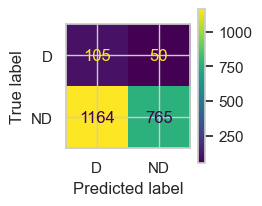

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [50]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.41746641074856045
ROC score on Test Set: 0.5539390290807539

              precision    recall  f1-score   support

           0       0.08      0.68      0.15       155
           1       0.94      0.40      0.56      1929

    accuracy                           0.42      2084
   macro avg       0.51      0.54      0.35      2084
weighted avg       0.87      0.42      0.53      2084



### XGBoost Classifier

#### Fold 1

In [51]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


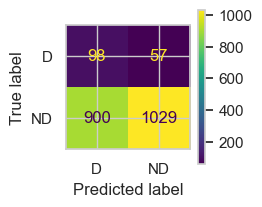

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5407869481765835
ROC score on Test Set: 0.6025167644943895

              precision    recall  f1-score   support

           0       0.10      0.63      0.17       155
           1       0.95      0.53      0.68      1929

    accuracy                           0.54      2084
   macro avg       0.52      0.58      0.43      2084
weighted avg       0.88      0.54      0.64      2084



#### Fold 2

In [54]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


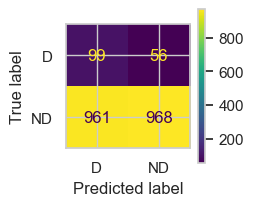

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.511996161228407
ROC score on Test Set: 0.5879730430274754

              precision    recall  f1-score   support

           0       0.09      0.64      0.16       155
           1       0.95      0.50      0.66      1929

    accuracy                           0.51      2084
   macro avg       0.52      0.57      0.41      2084
weighted avg       0.88      0.51      0.62      2084



#### Fold 3

In [57]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


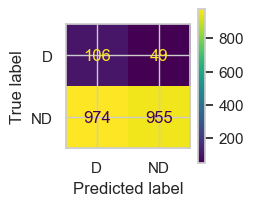

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5091170825335892
ROC score on Test Set: 0.6099851168079734

              precision    recall  f1-score   support

           0       0.10      0.68      0.17       155
           1       0.95      0.50      0.65      1929

    accuracy                           0.51      2084
   macro avg       0.52      0.59      0.41      2084
weighted avg       0.89      0.51      0.62      2084



#### Fold 4

In [60]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


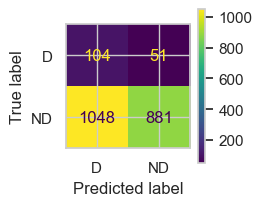

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.47264875239923226
ROC score on Test Set: 0.5790013210923259

              precision    recall  f1-score   support

           0       0.09      0.67      0.16       155
           1       0.95      0.46      0.62      1929

    accuracy                           0.47      2084
   macro avg       0.52      0.56      0.39      2084
weighted avg       0.88      0.47      0.58      2084



#### Fold 5

In [63]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, :] = dnd_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = dnd_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    620
1    620
Name: Result, dtype: int64
1    1929
0     155
Name: Result, dtype: int64


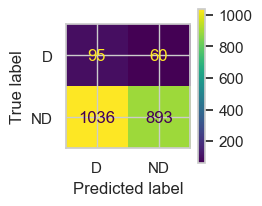

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [65]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4740882917466411
ROC score on Test Set: 0.5238699643806752

              precision    recall  f1-score   support

           0       0.08      0.61      0.15       155
           1       0.94      0.46      0.62      1929

    accuracy                           0.47      2084
   macro avg       0.51      0.54      0.38      2084
weighted avg       0.87      0.47      0.58      2084

